# Training a Protein Language Model with Transformers

In this notebook, we'll walk through the process of training a small protein language
model using the Transformer architecture. This model learns representations of protein
sequences by predicting masked amino acids, similar to how BERT learns language representations.

## Learning Objectives

By the end of this notebook, you will understand:
1. How to tokenize protein sequences for Transformer models
2. The architecture of a protein language model
3. How masked language modeling works for proteins
4. How to train and evaluate a Transformer on protein sequences
5. Modern training practices (warmup, gradient clipping, cosine scheduling)

## Setup and Imports

First, let's import the necessary libraries and modules:

In [2]:
import sys
from pathlib import Path

# Add parent directory to path so we can import src and scripts modules
notebook_dir = Path().resolve()
project_root = notebook_dir.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Our custom modules
from src.data import Tokenizer, ProteinSequenceDataset, mlm_collate_fn, mask_sequences
from src.model import ProteinLanguageModel, MultiheadAttention, EncoderLayer
from src.utils import set_seeds, get_device, scale_dot_product_attention
from scripts.train_plm import get_cosine_schedule_with_warmup, train_epoch, val_epoch, get_dataloaders

# Set random seeds for reproducibility
set_seeds()

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 4)

print("PyTorch version:", torch.__version__)
print("Device:", get_device())

PyTorch version: 2.9.1+cu128
Device: cpu


## Part 1: Understanding Protein Tokenization

Unlike natural language, proteins have a well-defined vocabulary: the 20 canonical amino acids.
We'll add special tokens for sequence boundaries and masking.

In [3]:
# Initialize the tokenizer
tokenizer = Tokenizer()

print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Special tokens:")
print(f"  - CLS token: '<cls>' (ID: {tokenizer.cls_token_id})")
print(f"  - PAD token: '<pad>' (ID: {tokenizer.pad_token_id})")
print(f"  - EOS token: '<eos>' (ID: {tokenizer.eos_token_id})")
print(f"  - MASK token: '<mask>' (ID: {tokenizer.mask_token_id})")
print(f"\nAmino acids in vocabulary:")
print(tokenizer.token_to_index)

Vocabulary size: 25
Special tokens:
  - CLS token: '<cls>' (ID: 0)
  - PAD token: '<pad>' (ID: 1)
  - EOS token: '<eos>' (ID: 2)
  - MASK token: '<mask>' (ID: 4)

Amino acids in vocabulary:
{'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, '<mask>': 4, 'A': 5, 'C': 6, 'D': 7, 'E': 8, 'F': 9, 'G': 10, 'H': 11, 'I': 12, 'K': 13, 'L': 14, 'M': 15, 'N': 16, 'P': 17, 'Q': 18, 'R': 19, 'S': 20, 'T': 21, 'V': 22, 'W': 23, 'Y': 24}


Let's tokenize some example protein sequences:

In [4]:
# Example sequences (small peptides for demonstration)
example_sequences = [
    "ACDEFGHIKLMNPQRSTVWY",  # All 20 amino acids
    "MKTAYIAKQRQISFVKSHFS",  # Example sequence 1
    "KALTARQQEVFDLIRD",      # Example sequence 2 (shorter)
]

# Tokenize the sequences
tokenized = tokenizer(example_sequences, padding=True)

print("Tokenized sequences:")
for i, seq in enumerate(example_sequences):
    print(f"\nSequence {i+1}: {seq}")
    print(f"  Length: {len(seq)}")
    print(f"  Tokens: {tokenized['input_ids'][i][:len(seq)+2]}")  # Show first few tokens
    print(f"  Attention mask: {tokenized['attention_mask'][i][:len(seq)+2]}")

Tokenized sequences:

Sequence 1: ACDEFGHIKLMNPQRSTVWY
  Length: 20
  Tokens: [0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2]
  Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Sequence 2: MKTAYIAKQRQISFVKSHFS
  Length: 20
  Tokens: [0, 15, 13, 21, 5, 24, 12, 5, 13, 18, 19, 18, 12, 20, 9, 22, 13, 20, 11, 9, 20, 2]
  Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Sequence 3: KALTARQQEVFDLIRD
  Length: 16
  Tokens: [0, 13, 5, 14, 21, 5, 19, 18, 18, 8, 22, 9, 7, 14, 12, 19, 7, 2]
  Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Part 2: Understanding Scaled Dot-Product Attention

The core of the Transformer is the attention mechanism. Let's visualize how it works:

Input shapes:
  Query (Q): torch.Size([1, 1, 6, 8])
  Key (K): torch.Size([1, 1, 6, 8])
  Value (V): torch.Size([1, 1, 6, 8])

Output shapes:
  Attention weights: torch.Size([1, 1, 6, 6])
  Output values: torch.Size([1, 1, 6, 8])


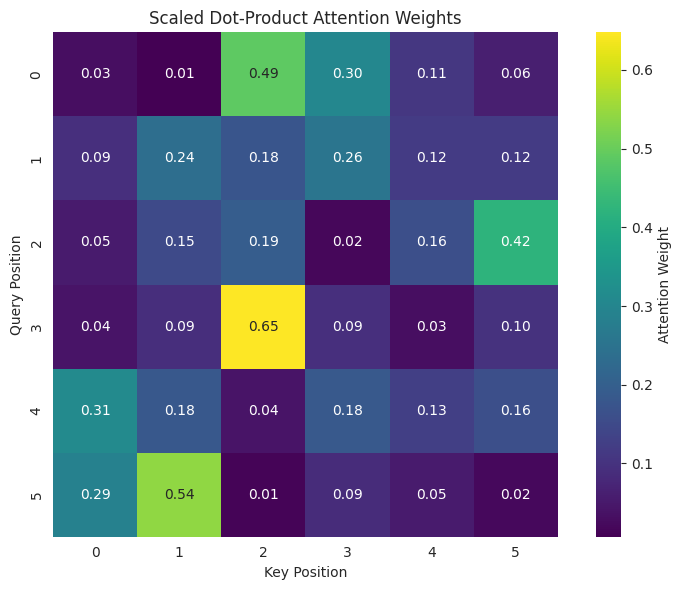

In [5]:
def visualize_attention(attention_weights, seq_length, title="Attention Pattern"):
    """Visualize attention weights as a heatmap."""
    fig, ax = plt.subplots(figsize=(8, 6))

    # Take first head, first batch for visualization
    attn = attention_weights[0, 0, :seq_length, :seq_length].detach().cpu().numpy()

    sns.heatmap(attn, annot=True, fmt='.2f', cmap='viridis',
                square=True, cbar_kws={'label': 'Attention Weight'})
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    ax.set_title(title)
    plt.tight_layout()
    return fig

# Create a small example
seq_len = 6
d_k = 8
batch_size = 1
num_heads = 1

# Random query, key, value vectors
torch.manual_seed(42)
q = torch.randn(batch_size, num_heads, seq_len, d_k)
k = torch.randn(batch_size, num_heads, seq_len, d_k)
v = torch.randn(batch_size, num_heads, seq_len, d_k)

# Compute attention
values, attention = scale_dot_product_attention(q, k, v)

print("Input shapes:")
print(f"  Query (Q): {q.shape}")
print(f"  Key (K): {k.shape}")
print(f"  Value (V): {v.shape}")
print(f"\nOutput shapes:")
print(f"  Attention weights: {attention.shape}")
print(f"  Output values: {values.shape}")

# Visualize
visualize_attention(attention, seq_len, "Scaled Dot-Product Attention Weights")
plt.show()

Notice how each row sums to 1.0 - these are the attention weights that determine
how much each position attends to every other position.

## Part 3: Multi-Head Attention

Multi-head attention allows the model to attend to different types of patterns simultaneously.
Let's see it in action:

Multi-Head Attention:
  Input shape: torch.Size([2, 10, 64])
  Output shape: torch.Size([2, 10, 64])
  Attention weights shape: torch.Size([2, 4, 10, 10])
    (batch_size, num_heads, seq_len, seq_len)


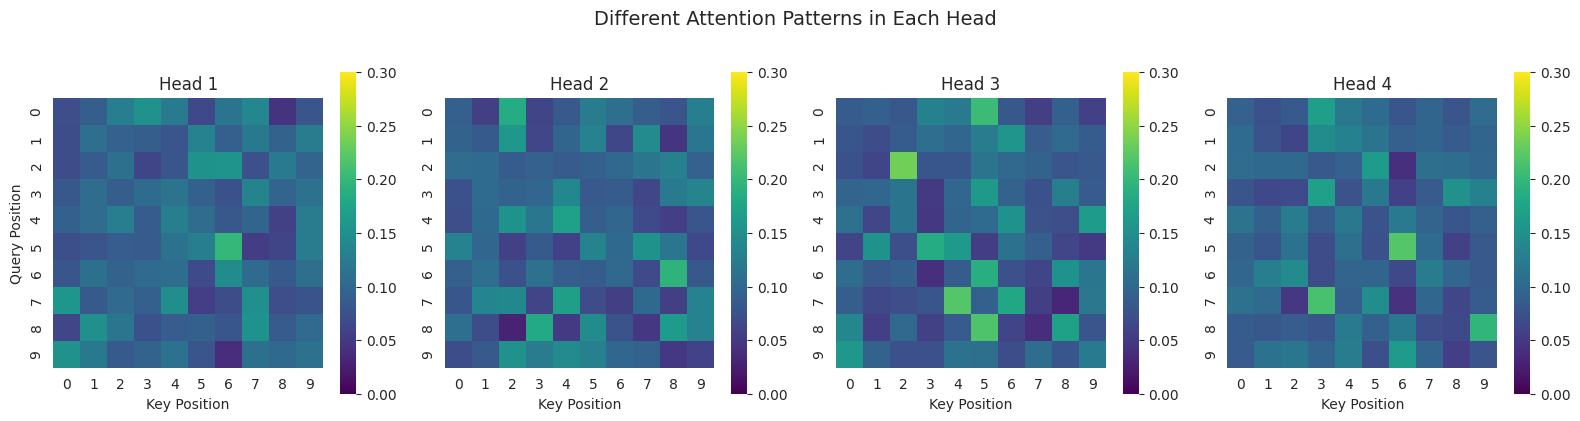

In [6]:
# Create a multi-head attention layer
embedding_dim = 64
num_heads = 4
mha = MultiheadAttention(embedding_dim=embedding_dim, num_heads=num_heads)

# Create example input (batch_size=2, seq_len=10, embedding_dim=64)
x = torch.randn(2, 10, embedding_dim)

# Forward pass
output, attention_weights = mha(x, return_attention=True)

print("Multi-Head Attention:")
print(f"  Input shape: {x.shape}")
print(f"  Output shape: {output.shape}")
print(f"  Attention weights shape: {attention_weights.shape}")
print(f"    (batch_size, num_heads, seq_len, seq_len)")

# Visualize different attention heads
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
seq_len = 10

for head_idx in range(num_heads):
    ax = axes[head_idx]
    attn = attention_weights[0, head_idx, :, :].detach().cpu().numpy()

    sns.heatmap(attn, annot=False, cmap='viridis', square=True,
                cbar=True, ax=ax, vmin=0, vmax=0.3)
    ax.set_title(f'Head {head_idx + 1}')
    ax.set_xlabel('Key Position')
    if head_idx == 0:
        ax.set_ylabel('Query Position')

plt.suptitle('Different Attention Patterns in Each Head', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Each head learns to attend to different patterns. Some heads might focus on local context,
while others capture long-range dependencies.

## Part 4: The Complete Transformer Encoder Layer

An encoder layer combines multi-head attention with a feed-forward network:

In [7]:
# Create an encoder layer
encoder_layer = EncoderLayer(
    embedding_dim=64,
    num_heads=4,
    ffn_dim=256,
    dropout=0.1
)

# Forward pass
x = torch.randn(2, 10, 64)
output = encoder_layer(x)

print("Transformer Encoder Layer:")
print(f"  Input shape: {x.shape}")
print(f"  Output shape: {output.shape}")
print(f"\nLayer components:")
print(f"  1. Multi-head attention")
print(f"  2. Add & Norm (residual connection + layer normalization)")
print(f"  3. Feed-forward network (Linear -> ReLU -> Dropout -> Linear)")
print(f"  4. Add & Norm (residual connection + layer normalization)")

Transformer Encoder Layer:
  Input shape: torch.Size([2, 10, 64])
  Output shape: torch.Size([2, 10, 64])

Layer components:
  1. Multi-head attention
  2. Add & Norm (residual connection + layer normalization)
  3. Feed-forward network (Linear -> ReLU -> Dropout -> Linear)
  4. Add & Norm (residual connection + layer normalization)


## Part 5: Masked Language Modeling

The key to training a protein language model is masked language modeling (MLM).
We randomly mask some amino acids and train the model to predict them.

In [8]:
# Load some example sequences
df = pd.read_parquet("../data/bcr_train.parquet")
print(f"Loaded {len(df)} protein sequences")
print(f"\nFirst few sequences:")
print(df["sequence"].head())

# Take a few sequences for demonstration
demo_sequences = df["sequence"].iloc[:5].tolist()

# Tokenize them
tokenized = tokenizer(demo_sequences, padding=True)
input_ids = torch.tensor(tokenized["input_ids"])

print(f"\nTokenized shape: {input_ids.shape}")

# Apply masking
special_token_ids = [tokenizer.pad_token_id, tokenizer.cls_token_id, tokenizer.eos_token_id]
masked_input_ids, labels, mask_positions = mask_sequences(
    input_ids=input_ids,
    mask_token_id=tokenizer.mask_token_id,
    vocab_size=tokenizer.vocab_size,
    special_token_ids=special_token_ids,
    mask_prob=0.15,
)

print(f"\nMasking statistics:")
print(f"  Total tokens: {input_ids.numel()}")
print(f"  Masked tokens: {(labels != -100).sum().item()}")
print(f"  Masking percentage: {(labels != -100).sum().item() / input_ids.numel() * 100:.1f}%")

Loaded 364 protein sequences

First few sequences:
1843    QVQLVQSGAEVKKPGASVTVSCQASGYTFTNYYVHWVRQAPGQGLQ...
1276    XVHLMQSGTEMKKPGASVRVTCQTSGYTFSDYFIHWLRQVPGRGFE...
6293    EVQLVESGGGLIQPGGSLRLSCAASGFTVSSNYMSWVRQAPGKGLE...
6016    AVGIGAVFLGFLGAAGSTMGAASMTLTVQARNLLSGIVQQQSNLLR...
6434    QVQLVEWGAGLLKPSETLSLTCAVYGGSFSGYYWSWIRQPPGKGLE...
Name: sequence, dtype: object

Tokenized shape: torch.Size([5, 230])

Masking statistics:
  Total tokens: 1150
  Masked tokens: 177
  Masking percentage: 15.4%


Let's visualize what masking looks like for one sequence:

In [9]:
def decode_tokens(token_ids, tokenizer):
    """Convert token IDs back to amino acids."""
    return ''.join([tokenizer.index_to_token.get(int(tid), '?') for tid in token_ids])

# Take first sequence
seq_idx = 0
original_ids = input_ids[seq_idx]
masked_ids = masked_input_ids[seq_idx]
target_labels = labels[seq_idx]

# Find non-padding positions
non_pad = (original_ids != tokenizer.pad_token_id)
seq_length = non_pad.sum().item()

print("Original sequence:")
print(decode_tokens(original_ids[:seq_length], tokenizer))
print("\nMasked sequence:")
print(decode_tokens(masked_ids[:seq_length], tokenizer))
print("\nPositions to predict (green = masked):")

# Show which positions are masked
for i in range(seq_length):
    original_token = tokenizer.index_to_token[int(original_ids[i])]
    masked_token = tokenizer.index_to_token[int(masked_ids[i])]
    is_masked = target_labels[i] != -100

    if is_masked:
        print(f"  Position {i:2d}: {masked_token:6s} -> {original_token:6s} ✓")

Original sequence:
<cls>QVQLVQSGAEVKKPGASVTVSCQASGYTFTNYYVHWVRQAPGQGLQLMGWIDPSWGRTNYAQNFQGRITMTRDTSTSTVYMEMRSLRSEDTAVYYCARNVATEGSLLHYDYWGQGTLVTVSAASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKRVEPKSC<eos>

Masked sequence:
<cls>QVQL<mask>QS<mask>AEAKKP<mask><mask><mask>VT<mask>SCQ<mask>SGYTFTNY<mask>VHWVRQ<mask>PGQGL<mask>LMG<mask>IDPSWGRT<mask>YAQ<mask>FQGRITMT<mask><mask>TSTSTVYMEMRSLRSED<mask><mask>VYYCARNVAT<mask>GSLL<mask>YDYWGQGTL<mask>TVSAA<mask>TKGPSV<mask>PLAPSS<mask>ST<mask>GGT<mask>ALG<mask>LVKDYFPEP<mask>TVSWNSGALTS<mask>VHTFP<mask>VLQSSGLYSLSSVVTVPS<mask>SL<mask>TQTYIC<mask>V<mask>HKPSNTKVDKRV<mask>PK<mask>C<eos>

Positions to predict (green = masked):
  Position  5: <mask> -> V      ✓
  Position  8: <mask> -> G      ✓
  Position 11: A      -> V      ✓
  Position 15: <mask> -> G      ✓
  Position 16: <mask> -> A      ✓
  Position 17: <mask> -> S      ✓
  Position 20: <mask> -> V      ✓
  Position 24: <mask> -> A      ✓
  Po

## Part 6: Building the Protein Language Model

Now let's create a complete protein language model:

In [10]:
# Model hyperparameters
model_config = {
    "vocab_size": tokenizer.vocab_size,
    "padding_idx": tokenizer.pad_token_id,
    "embedding_dim": 128,
    "num_layers": 4,
    "num_heads": 4,
    "ffn_dim": 512,
    "dropout": 0.1,
}

# Create model
model = ProteinLanguageModel(**model_config)
device = get_device()
model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Protein Language Model Architecture:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"\nModel configuration:")
for key, value in model_config.items():
    print(f"  {key}: {value}")

Protein Language Model Architecture:
  Total parameters: 799,513
  Trainable parameters: 799,513

Model configuration:
  vocab_size: 25
  padding_idx: 1
  embedding_dim: 128
  num_layers: 4
  num_heads: 4
  ffn_dim: 512
  dropout: 0.1


Let's do a forward pass to see what the model outputs:

In [11]:
# Create a small batch
batch_sequences = demo_sequences[:2]
tokenized = tokenizer(batch_sequences, padding=True)

batch = {
    "input_ids": torch.tensor(tokenized["input_ids"], device=device),
    "attention_mask": torch.tensor(tokenized["attention_mask"], device=device),
}

# Forward pass
with torch.no_grad():
    logits = model(batch)

print("Model output:")
print(f"  Input shape: {batch['input_ids'].shape} (batch_size, seq_len)")
print(f"  Output shape: {logits.shape} (batch_size, seq_len, vocab_size)")
print(f"\nFor each position, the model outputs a probability distribution over {tokenizer.vocab_size} tokens")

# Show predictions for first sequence
seq_len = (batch['attention_mask'][0] == 1).sum()
predicted_ids = torch.argmax(logits[0, :seq_len], dim=-1)

print(f"\nExample predictions (before training, random):")
print(f"  Input:     {decode_tokens(batch['input_ids'][0, :seq_len], tokenizer)}")
print(f"  Predicted: {decode_tokens(predicted_ids, tokenizer)}")

Model output:
  Input shape: torch.Size([2, 229]) (batch_size, seq_len)
  Output shape: torch.Size([2, 229, 25]) (batch_size, seq_len, vocab_size)

For each position, the model outputs a probability distribution over 25 tokens

Example predictions (before training, random):
  Input:     <cls>QVQLVQSGAEVKKPGASVTVSCQASGYTFTNYYVHWVRQAPGQGLQLMGWIDPSWGRTNYAQNFQGRITMTRDTSTSTVYMEMRSLRSEDTAVYYCARNVATEGSLLHYDYWGQGTLVTVSAASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKRVEPKSC<eos>
  Predicted: AHHHPLFAIYCEEEAEYA<cls>C<cls>AEEAAEECACYYE<cls>AYYSEYREFFCFASYYHW<pad>AYYSCYYYYYYHY<cls>HCWC<cls>FCACYCYYRCRSAASACWCA<cls>YIDA<cls>YYACCAA<cls><cls>IIWYT<pad>FSCA<cls>C<cls>AAAACNI<pad>A<cls>A<pad><cls>YRAAAACAIICAYARDAYAWIARC<pad>LCLAT<pad>AIAACAY<cls>ICAVA<cls>YFAAYAYAAAA<cls><cls>MYMAAAYYFFCIFDA<cls>YAARAYCA<cls>AA<cls><cls>CAAAE<cls>


## Part 7: Training the Model

Now let's train the model with modern best practices:
- AdamW optimizer with weight decay
- Learning rate warmup
- Cosine annealing schedule
- Gradient clipping

In [12]:
# Training configuration
train_config = {
    "batch_size": 1,
    "lr": 5e-4,
    "weight_decay": 0.01,
    "num_epochs": 10,  # Small number for demo
    "warmup_steps": 100,
    "max_grad_norm": 1.0,
    "mask_prob": 0.15,
    "val_size": 0.15,
}

print("Training configuration:")
for key, value in train_config.items():
    print(f"  {key}: {value}")

# Create dataloaders
train_dl, val_dl = get_dataloaders(
    df=df,
    val_size=train_config["val_size"],
    tokenizer=tokenizer,
    device=device,
    batch_size=train_config["batch_size"],
    mask_prob=train_config["mask_prob"],
)

print(f"\nDataset splits:")
print(f"  Training batches: {len(train_dl)}")
print(f"  Validation batches: {len(val_dl)}")
print(f"  Training samples: {len(train_dl.dataset)}")
print(f"  Validation samples: {len(val_dl.dataset)}")

Training configuration:
  batch_size: 1
  lr: 0.0005
  weight_decay: 0.01
  num_epochs: 10
  warmup_steps: 100
  max_grad_norm: 1.0
  mask_prob: 0.15
  val_size: 0.15

Dataset splits:
  Training batches: 309
  Validation batches: 55
  Training samples: 309
  Validation samples: 55


Set up the optimizer and learning rate scheduler:

Total training steps: 3090
Warmup steps: 100


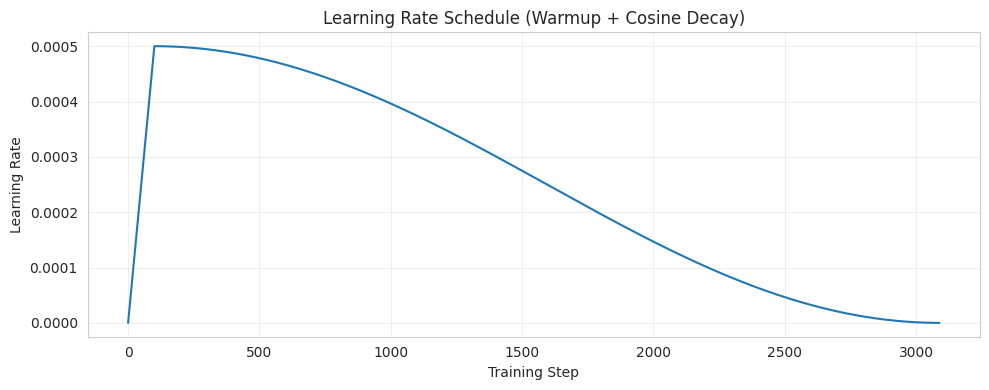

In [13]:
# Loss function (ignores -100 labels for non-masked positions)
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

# Optimizer with weight decay
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=train_config["lr"],
    weight_decay=train_config["weight_decay"],
)

# Learning rate scheduler with warmup
num_training_steps = len(train_dl) * train_config["num_epochs"]
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=train_config["warmup_steps"],
    num_training_steps=num_training_steps,
)

print(f"Total training steps: {num_training_steps}")
print(f"Warmup steps: {train_config['warmup_steps']}")

# Visualize learning rate schedule
lrs = []
for _ in range(num_training_steps):
    lrs.append(scheduler.get_last_lr()[0])
    optimizer.step()
    scheduler.step()

plt.figure(figsize=(10, 4))
plt.plot(lrs)
plt.xlabel('Training Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule (Warmup + Cosine Decay)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Reset optimizer and scheduler for actual training
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=train_config["lr"],
    weight_decay=train_config["weight_decay"],
)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=train_config["warmup_steps"],
    num_training_steps=num_training_steps,
)

Train the model:

In [14]:
import math

# Training loop
history = {
    "train_loss": [],
    "train_perplexity": [],
    "val_loss": [],
    "val_perplexity": [],
    "val_accuracy": [],
}

print("Starting training...")
print("-" * 80)

best_val_loss = float('inf')

for epoch in range(1, train_config["num_epochs"] + 1):
    # Train
    train_loss, train_ppl = train_epoch(
        model=model,
        train_dl=train_dl,
        loss_fn=loss_fn,
        opt=optimizer,
        scheduler=scheduler,
        max_grad_norm=train_config["max_grad_norm"],
    )

    # Validate
    val_loss, val_ppl, val_acc = val_epoch(
        model=model,
        val_dl=val_dl,
        loss_fn=loss_fn,
    )

    # Track history
    history["train_loss"].append(train_loss)
    history["train_perplexity"].append(train_ppl)
    history["val_loss"].append(val_loss)
    history["val_perplexity"].append(val_ppl)
    history["val_accuracy"].append(val_acc)

    # Update best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch

    # Print progress
    print(
        f"Epoch {epoch:2d}/{train_config['num_epochs']}: "
        f"Train Loss: {train_loss:.4f}, Train PPL: {train_ppl:6.2f} | "
        f"Val Loss: {val_loss:.4f}, Val PPL: {val_ppl:6.2f}, Val Acc: {val_acc:.4f}"
    )

print("-" * 80)
print(f"Training complete! Best validation loss: {best_val_loss:.4f} at epoch {best_epoch}")

Starting training...
--------------------------------------------------------------------------------
Epoch  1/10: Train Loss: 2.4253, Train PPL:  11.31 | Val Loss: 2.1259, Val PPL:   8.38, Val Acc: 0.3422
Epoch  2/10: Train Loss: 2.0687, Train PPL:   7.91 | Val Loss: 2.0706, Val PPL:   7.93, Val Acc: 0.3690
Epoch  3/10: Train Loss: 2.0358, Train PPL:   7.66 | Val Loss: 1.9129, Val PPL:   6.77, Val Acc: 0.4049
Epoch  4/10: Train Loss: 1.9788, Train PPL:   7.23 | Val Loss: 1.9012, Val PPL:   6.69, Val Acc: 0.4137
Epoch  5/10: Train Loss: 1.9322, Train PPL:   6.90 | Val Loss: 1.9085, Val PPL:   6.74, Val Acc: 0.4133
Epoch  6/10: Train Loss: 1.9044, Train PPL:   6.72 | Val Loss: 1.8525, Val PPL:   6.38, Val Acc: 0.4163
Epoch  7/10: Train Loss: 1.8857, Train PPL:   6.59 | Val Loss: 1.7645, Val PPL:   5.84, Val Acc: 0.4513
Epoch  8/10: Train Loss: 1.8307, Train PPL:   6.24 | Val Loss: 1.7747, Val PPL:   5.90, Val Acc: 0.4626
Epoch  9/10: Train Loss: 1.8261, Train PPL:   6.21 | Val Loss: 1.8

Visualize training progress:

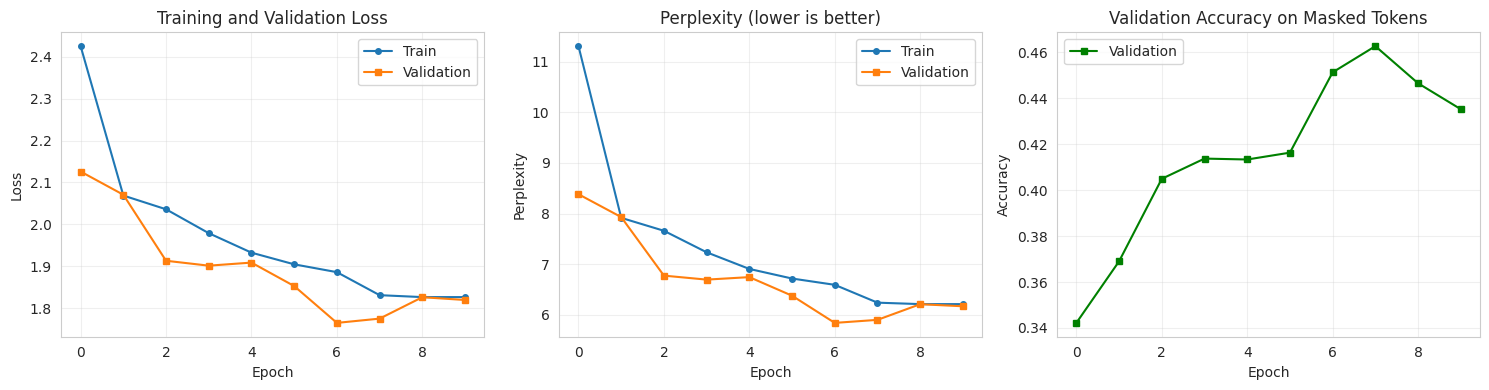

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot loss
ax = axes[0]
ax.plot(history["train_loss"], label="Train", marker='o', markersize=4)
ax.plot(history["val_loss"], label="Validation", marker='s', markersize=4)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot perplexity
ax = axes[1]
ax.plot(history["train_perplexity"], label="Train", marker='o', markersize=4)
ax.plot(history["val_perplexity"], label="Validation", marker='s', markersize=4)
ax.set_xlabel('Epoch')
ax.set_ylabel('Perplexity')
ax.set_title('Perplexity (lower is better)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot accuracy
ax = axes[2]
ax.plot(history["val_accuracy"], label="Validation", marker='s', markersize=4, color='green')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Validation Accuracy on Masked Tokens')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 8: Evaluating the Trained Model

Let's see how well our model can predict masked amino acids:

In [16]:
model.eval()

# Take some test sequences
test_sequences = df["sequence"].iloc[100:103].tolist()

for seq_idx, sequence in enumerate(test_sequences):
    print(f"\nSequence {seq_idx + 1}: {sequence}")
    print("-" * 60)

    # Tokenize
    tokenized = tokenizer([sequence], padding=True)
    input_ids = torch.tensor(tokenized["input_ids"], device=device)
    attention_mask = torch.tensor(tokenized["attention_mask"], device=device)

    # Manually mask a few positions for demonstration
    original_ids = input_ids.clone()
    seq_len = (attention_mask[0] == 1).sum()

    # Mask positions 3, 7, 11 (if they exist)
    mask_positions = [3, 7, 11]
    mask_positions = [p for p in mask_positions if p < seq_len]

    for pos in mask_positions:
        input_ids[0, pos] = tokenizer.mask_token_id

    # Get predictions
    with torch.no_grad():
        batch = {"input_ids": input_ids, "attention_mask": attention_mask}
        logits = model(batch)
        predictions = torch.argmax(logits, dim=-1)

    # Show results
    print("Predictions:")
    for pos in mask_positions:
        original_aa = tokenizer.index_to_token[int(original_ids[0, pos])]
        predicted_aa = tokenizer.index_to_token[int(predictions[0, pos])]

        # Get top 3 predictions with probabilities
        probs = torch.softmax(logits[0, pos], dim=-1)
        top_probs, top_indices = torch.topk(probs, k=3)

        top_aas = [tokenizer.index_to_token[int(idx)] for idx in top_indices]
        top_prob_values = [float(p) for p in top_probs]

        match = "✓" if predicted_aa == original_aa else "✗"
        print(f"  Position {pos}: {original_aa} -> {predicted_aa} {match}")
        print(f"    Top 3: {top_aas[0]}({top_prob_values[0]:.3f}), "
              f"{top_aas[1]}({top_prob_values[1]:.3f}), "
              f"{top_aas[2]}({top_prob_values[2]:.3f})")


Sequence 1: QVQLVESGGGVVQPGRSLRLSCAASGFTFSSYGMHWVRQAPGKGLEWVAVISYDGSNKHYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCAKDSGYNYGYSWFDPWGQGTLVTVSSASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKKVEPKSCDKTH
------------------------------------------------------------
Predictions:
  Position 3: Q -> Q ✓
    Top 3: Q(0.718), L(0.131), V(0.088)
  Position 7: S -> S ✓
    Top 3: S(0.824), G(0.088), Q(0.034)
  Position 11: V -> V ✓
    Top 3: V(0.673), L(0.189), K(0.029)

Sequence 2: QVQLLQSGAQVKKTGASMRISCKTSGYTFLNCPINWVRQAPGRGLEWMGWMKPRGGAVNYPQKFQGRVTMTRDMSTDTAFLDMSNLRSDDTAVYFCARGKYCTASDYYNWDFEHWGRGTLVTVSSPATKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKKVEPKSC
------------------------------------------------------------
Predictions:
  Position 3: Q -> Q ✓
    Top 3: Q(0.704), L(0.135), V(0.096)
  Position 7: S -> S ✓
    Top 3: S(0.834), G(0.073), Q(0.037)
  Position 11: V -> V ✓
    Top 3: V(0.699), L(0.16

## Part 9: Visualizing Learned Attention Patterns

One of the most interesting aspects of Transformers is that we can visualize
what the model has learned to attend to:

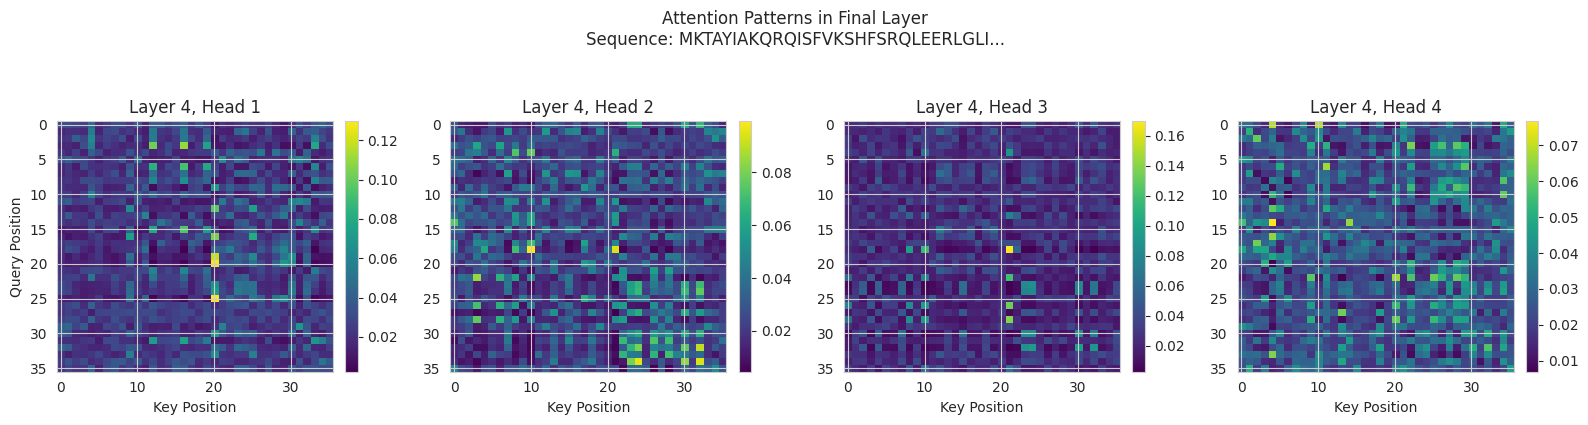

In [17]:
# Get attention weights for a sequence
test_seq = "MKTAYIAKQRQISFVKSHFSRQLEERLGLIEDESGK"
tokenized = tokenizer([test_seq], padding=False)

batch = {
    "input_ids": torch.tensor(tokenized["input_ids"], device=device),
    "attention_mask": torch.tensor(tokenized["attention_mask"], device=device),
}

# Get attention weights from the encoder
model.eval()
with torch.no_grad():
    x = model.embedding(batch["input_ids"])
    x = model.pe(x)
    attention_maps = model.encoder.get_attentions(x, batch["attention_mask"])

# Visualize attention from the last layer
last_layer_attention = attention_maps[-1]  # Shape: (1, num_heads, seq_len, seq_len)
seq_len = (batch["attention_mask"][0] == 1).sum().item()

# Plot all heads from the last layer
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for head_idx in range(4):
    ax = axes[head_idx]
    attn = last_layer_attention[0, head_idx, 1:seq_len-1, 1:seq_len-1].cpu().numpy()

    im = ax.imshow(attn, cmap='viridis', aspect='auto')
    ax.set_title(f'Layer 4, Head {head_idx + 1}')
    ax.set_xlabel('Key Position')
    if head_idx == 0:
        ax.set_ylabel('Query Position')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f'Attention Patterns in Final Layer\nSequence: {test_seq[:30]}...',
             fontsize=12, y=1.05)
plt.tight_layout()
plt.show()

Saved figures:
  - attention_patterns_final_layer.png (high-res raster)
  - attention_patterns_final_layer.svg (vector)


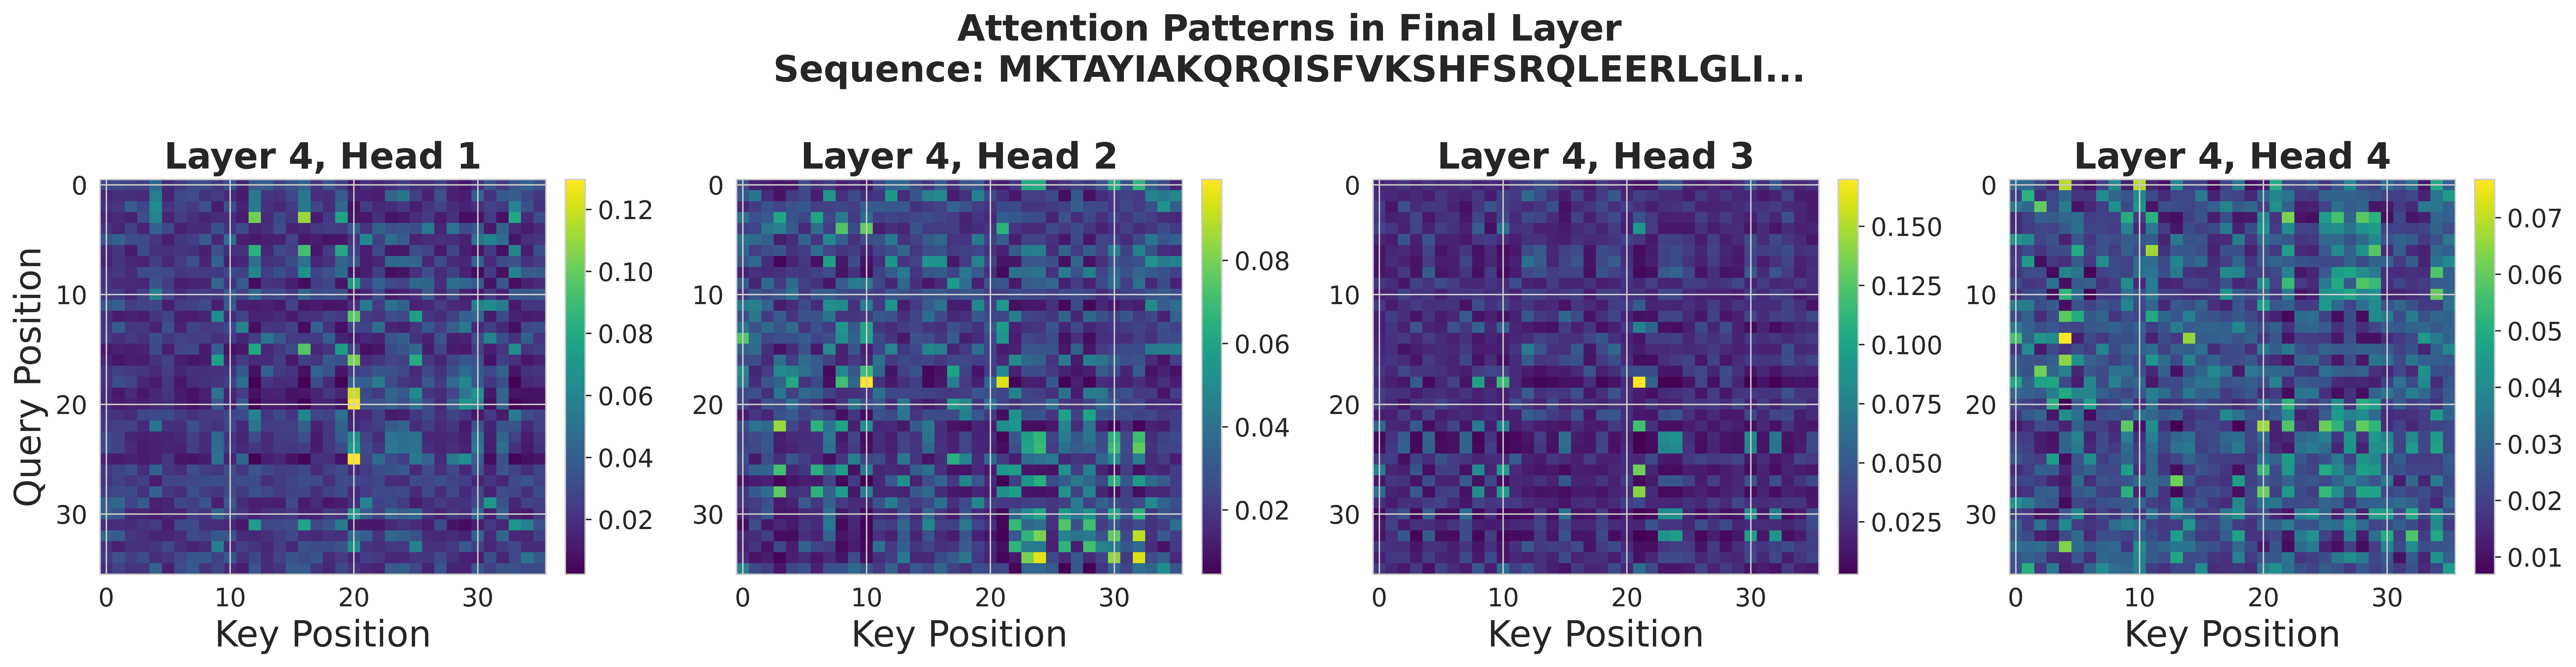

In [18]:
#import matplotlib.pyplot as plt
#import cmocean  # You may need to: pip install cmocean

# Get attention weights for a sequence
test_seq = "MKTAYIAKQRQISFVKSHFSRQLEERLGLIEDESGK"
tokenized = tokenizer([test_seq], padding=False)

batch = {
    "input_ids": torch.tensor(tokenized["input_ids"], device=device),
    "attention_mask": torch.tensor(tokenized["attention_mask"], device=device),
}

# Get attention weights from the encoder
model.eval()
with torch.no_grad():
    x = model.embedding(batch["input_ids"])
    x = model.pe(x)
    attention_maps = model.encoder.get_attentions(x, batch["attention_mask"])

# Visualize attention from the last layer
last_layer_attention = attention_maps[-1]  # Shape: (1, num_heads, seq_len, seq_len)
seq_len = (batch["attention_mask"][0] == 1).sum().item()

# Set up figure with larger size for publication quality
fig, axes = plt.subplots(1, 4, figsize=(20, 5), dpi=600)

# Configure font sizes for publication
TITLE_SIZE = 20
LABEL_SIZE = 20
TICK_SIZE = 14
SUPTITLE_SIZE = 20

for head_idx in range(4):
    ax = axes[head_idx]
    attn = last_layer_attention[0, head_idx, 1:seq_len-1, 1:seq_len-1].cpu().numpy()

    # Use cmocean diff_r colormap
    im = ax.imshow(attn, cmap="viridis", aspect='auto')
    
    # Set larger font sizes
    ax.set_title(f'Layer 4, Head {head_idx + 1}', fontsize=TITLE_SIZE, fontweight='bold')
    ax.set_xlabel('Key Position', fontsize=LABEL_SIZE)
    if head_idx == 0:
        ax.set_ylabel('Query Position', fontsize=LABEL_SIZE)
    
    # Increase tick label size
    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
    
    # Add colorbar with larger font
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=TICK_SIZE)

plt.suptitle(f'Attention Patterns in Final Layer\nSequence: {test_seq[:30]}...',
             fontsize=SUPTITLE_SIZE, fontweight='bold', y=1.02)
plt.tight_layout()

# Save as high-quality PNG and SVG
output_path = Path('attention_patterns_final_layer')
plt.savefig(f'{output_path}.png', dpi=600, bbox_inches='tight', facecolor='white')
#plt.savefig(f'{output_path}.svg', bbox_inches='tight', facecolor='white')

print(f"Saved figures:")
print(f"  - {output_path}.png (high-res raster)")
print(f"  - {output_path}.svg (vector)")

plt.show()

## Summary

In this notebook, we've covered:

1. **Tokenization**: How to convert protein sequences into numerical representations
2. **Attention Mechanism**: The scaled dot-product attention that powers Transformers
3. **Multi-Head Attention**: How multiple attention heads capture different patterns
4. **Transformer Architecture**: Building encoder layers and stacking them
5. **Masked Language Modeling**: The training objective for protein language models
6. **Modern Training Practices**: Warmup, cosine scheduling, gradient clipping
7. **Evaluation**: How to assess model performance on masked prediction
8. **Visualization**: Interpreting learned attention patterns

## Key Takeaways

- **Global Attention**: Unlike RNNs, Transformers allow every position to attend to every other position
- **Parallel Processing**: All positions are processed simultaneously, enabling faster training
- **Learned Dependencies**: The model discovers which amino acids interact through data
- **Perplexity**: Measures how well the model predicts masked amino acids (lower is better)
- **Attention Patterns**: Visualization reveals what the model has learned about protein structure